<a href="https://colab.research.google.com/github/Manan1811/fifa20-ratings/blob/master/FIFA_NB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch

import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
import keras
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
path = "/content/drive/My Drive/FIFA_20.csv"
fifa= pd.read_csv(path)
fifa.head()


,overall,name,nationality,club,position,preferred_foot,work_rate,jersey_number,wage_eur,international_reputation,weak_foot,skill_moves,age,height_cm,weight_kg,pace,shooting,passing,dribbling,defending,physic,finishing,fk_accuracy,acceleration,agility,stamina,penalties,composure,standing_tackle,sliding_tackle
0,94,L. Messi,Argentina,FC Barcelona,Midfielder,Left,Medium,10,565000,5,4,4,32,170,72,87,92,92,96,39,66,95,94,91,93,75,75,96,37,26
1,93,Cristiano Ronaldo,Portugal,Juventus,Midfielder,Right,High,7,405000,5,4,5,34,187,83,90,93,82,89,35,78,94,76,89,87,85,85,95,32,24
2,92,Neymar Jr,Brazil,Paris Saint-Germain,Midfielder,Right,High,10,290000,5,5,5,27,175,68,91,85,87,95,32,58,87,87,94,96,81,90,94,26,29
3,91,E. Hazard,Belgium,Real Madrid,Midfielder,Right,High,7,470000,4,4,4,28,175,74,91,83,86,94,35,66,84,79,94,95,84,88,91,27,22
4,91,K. De Bruyne,Belgium,Manchester City,Midfielder,Right,High,17,370000,4,5,4,28,181,70,76,86,92,86,61,78,82,83,77,78,89,79,91,58,51


In [ ]:
skill_cols = [col for col in fifa.columns if col not in ('name', 'nationality', 'club', 'position', 
                                                         'preferred_foot', 'work_rate', 'jersey_number', 
                                                         'international_reputation', 'weak_foot', 'skill_moves', 
                                                         'wage_eur', 'age', 'height_cm', 'weight_kg')]
fifa= pd.read_csv(path, usecols=skill_cols)
fifa.head()

,overall,pace,shooting,passing,dribbling,defending,physic,finishing,fk_accuracy,acceleration,agility,stamina,penalties,composure,standing_tackle,sliding_tackle
0,94,87,92,92,96,39,66,95,94,91,93,75,75,96,37,26
1,93,90,93,82,89,35,78,94,76,89,87,85,85,95,32,24
2,92,91,85,87,95,32,58,87,87,94,96,81,90,94,26,29
3,91,91,83,86,94,35,66,84,79,94,95,84,88,91,27,22
4,91,76,86,92,86,61,78,82,83,77,78,89,79,91,58,51


#DEEP Learning Model

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sys

import keras
from keras.layers import Conv2D, Conv2DTranspose, UpSampling2D, MaxPool2D, Flatten, BatchNormalization
from keras.layers import Conv1D, MaxPool1D, Reshape
from keras.layers import Input, Dense, Dropout, Activation, Add, Concatenate
from keras.datasets import cifar10, mnist
from keras import regularizers
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.optimizers import SGD, Adam, RMSprop, Adadelta
import keras.backend as K
from keras.objectives import mean_squared_error
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils

from sklearn.utils import class_weight
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, LabelBinarizer, RobustScaler, StandardScaler

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [ ]:
y=fifa[['overall']]
X=fifa.drop(columns=['overall'], axis=1)
X=X.values
X



array([[87, 92, 92, ..., 96, 37, 26],
       [90, 93, 82, ..., 95, 32, 24],
       [91, 85, 87, ..., 94, 26, 29],
       ...,
       [54, 35, 44, ..., 39, 52, 46],
       [59, 35, 47, ..., 40, 44, 54],
       [60, 32, 51, ..., 42, 42, 48]])

In [ ]:
y=y.values
y

array([[94],
       [93],
       [92],
       ...,
       [48],
       [48],
       [48]])

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_train = StandardScaler().fit_transform(X_train)
y_train = StandardScaler().fit_transform(y_train)

In [ ]:
X_test = StandardScaler().fit_transform(X_test)
transformer = StandardScaler()
transformer.fit(y_test)
# difference transform
transformed = transformer.transform(y_test)
print(transformed)
# invert difference
inverted = transformer.inverse_transform(transformed)
print(inverted)

[[-0.92336124]
 [ 0.68002957]
 [ 0.68002957]
 ...
 [ 0.38850397]
 [-0.48607284]
 [-1.65217525]]
[[60.]
 [71.]
 [71.]
 ...
 [69.]
 [63.]
 [55.]]


In [ ]:
model = Sequential()
model.add(Dense(16, input_dim=15, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(8, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_105 (Dense)            (None, 16)                256       
_________________________________________________________________
dropout_34 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_106 (Dense)            (None, 8)                 136       
_________________________________________________________________
batch_normalization_64 (Batc (None, 8)                 32        
_________________________________________________________________
dense_107 (Dense)            (None, 1)                 9         
Total params: 433
Trainable params: 417
Non-trainable params: 16
_________________________________________________________________


In [ ]:
model.compile(loss='mse', optimizer='adam')
history=model.fit(X_train, y_train,validation_split=0.1,epochs=20,shuffle=True)


Epoch 1/20
361/361 [==============================] - 1s 3ms/step - loss: 0.8166 - val_loss: 0.6153
Epoch 2/20
361/361 [==============================] - 1s 3ms/step - loss: 0.7049 - val_loss: 0.5987
Epoch 3/20
361/361 [==============================] - 1s 3ms/step - loss: 0.6863 - val_loss: 0.5932
Epoch 4/20
361/361 [==============================] - 1s 3ms/step - loss: 0.6707 - val_loss: 0.5903
Epoch 5/20
361/361 [==============================] - 1s 3ms/step - loss: 0.6656 - val_loss: 0.5977
Epoch 6/20
361/361 [==============================] - 1s 3ms/step - loss: 0.6584 - val_loss: 0.5949
Epoch 7/20
361/361 [==============================] - 1s 3ms/step - loss: 0.6543 - val_loss: 0.5918
Epoch 8/20
361/361 [==============================] - 1s 3ms/step - loss: 0.6488 - val_loss: 0.6017
Epoch 9/20
361/361 [==============================] - 1s 3ms/step - loss: 0.6420 - val_loss: 0.6030
Epoch 10/20
361/361 [==============================] - 1s 3ms/step - loss: 0.6419 - val_loss: 0.5996

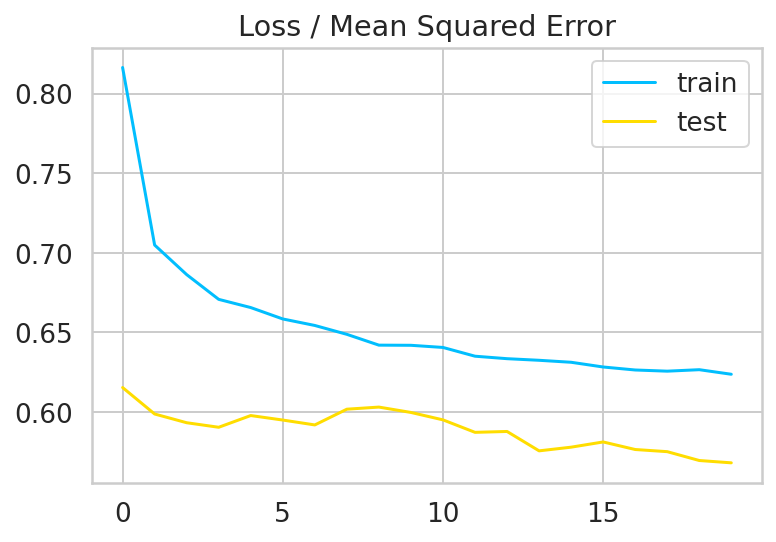

In [ ]:
from matplotlib import pyplot
pyplot.title('Loss / Mean Squared Error')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
y_pred=model.predict(X_test)
y_pred

array([[3.3202925e-04],
       [6.3208884e-01],
       [2.6280034e-01],
       ...,
       [1.7577501e-02],
       [5.4595852e-03],
       [3.9438310e-04]], dtype=float32)

In [ ]:
yhat=transformer.inverse_transform(y_pred)
yhat[:20]

array([[66.33696 ],
       [70.671104],
       [68.13761 ],
       [66.33699 ],
       [66.47997 ],
       [66.547874],
       [66.339554],
       [66.35527 ],
       [66.444244],
       [67.61984 ],
       [69.22238 ],
       [72.572624],
       [66.41134 ],
       [66.33773 ],
       [66.470665],
       [66.34769 ],
       [71.081474],
       [66.36747 ],
       [66.33909 ],
       [73.06226 ]], dtype=float32)

In [ ]:
y_test[:20]

array([[60],
       [71],
       [71],
       [54],
       [67],
       [69],
       [55],
       [63],
       [68],
       [70],
       [69],
       [75],
       [65],
       [62],
       [67],
       [64],
       [75],
       [65],
       [58],
       [75]])

In [ ]:
from sklearn.metrics import r2_score
r2_score(y_test, yhat)

0.3823720159058923